In [183]:
import warnings
warnings.filterwarnings('ignore')
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from urllib.parse import urlparse
import re
import whois
import datetime
import requests
from wordcloud import WordCloud

In [3]:
# This is main refrences to extract features from URLs
#https://towardsdatascience.com/phishing-domain-detection-with-ml-5be9c99293e5
#https://arxiv.org/pdf/2205.05121.pdf

## Data reading

- reading the CSV

In [4]:
df = pd.read_csv('malicious_phish.csv')
print('Shape of DataFrame:', df.shape)
print('Size of DataFrame:', df.size)
df_copy = df.copy()

Shape of DataFrame: (651191, 2)
Size of DataFrame: 1302382


- checking first five rows

In [5]:
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


- checking last five rows

In [6]:
df.tail()


,url,type
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing
651190,www.angelfire.com/goth/devilmaycrytonite/,phishing


## concise summary of our dataset

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


## Describing the Data

In [8]:
df.describe(exclude='number').T

,count,unique,top,freq
url,651191,641119,http://style.org.hc360.com/css/detail/mysite/s...,180
type,651191,4,benign,428103


## Checking for null values

In [9]:
df.isna().sum()

url     0
type    0
dtype: int64

## Checking if there are duplicates

In [10]:
df.duplicated().sum()

10066

In [11]:
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

(651191, 2)
(641125, 2)


## Data Sampling

In [12]:
malware_data = df[df['type']=='malware'].head(1000)
benign_data = df[df['type']=='benign'].head(3000)
defacement_data = df[df['type']=='defacement'].head(1000)
phishing_data = df[df['type']=='phishing'].head(1000)

In [13]:
df = pd.concat([malware_data,benign_data,defacement_data,phishing_data]).reset_index()

In [14]:
df.drop('index',axis=1,inplace=True)

In [15]:
df.head()

,url,type
0,http://www.824555.com/app/member/SportOption.p...,malware
1,http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...,malware
2,http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...,malware
3,http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E...,malware
4,http://chinacxyy.com/piccodejs-000.asp?lm2=191...,malware


## Data ploting

In [177]:
df_copy.type.value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [178]:
countTypes = pd.DataFrame({'type':['benign','defacement','phishing','malware'],
                      'count':[428103,96457,94111,32520]})

In [325]:
fig = px.bar(data_frame=countTypes, x='type',y='count',title='Counts of each type').update_layout(title_x=0.5)
fig.show()


### We found that the dataset was unblanced between the 4 types, so we balnced the data by taking sample of each type

In [186]:
df_phish = df_copy[df_copy.type=='phishing']
df_malware = df_copy[df_copy.type=='malware']
df_deface = df_copy[df_copy.type=='defacement']
df_benign = df_copy[df_copy.type=='benign']

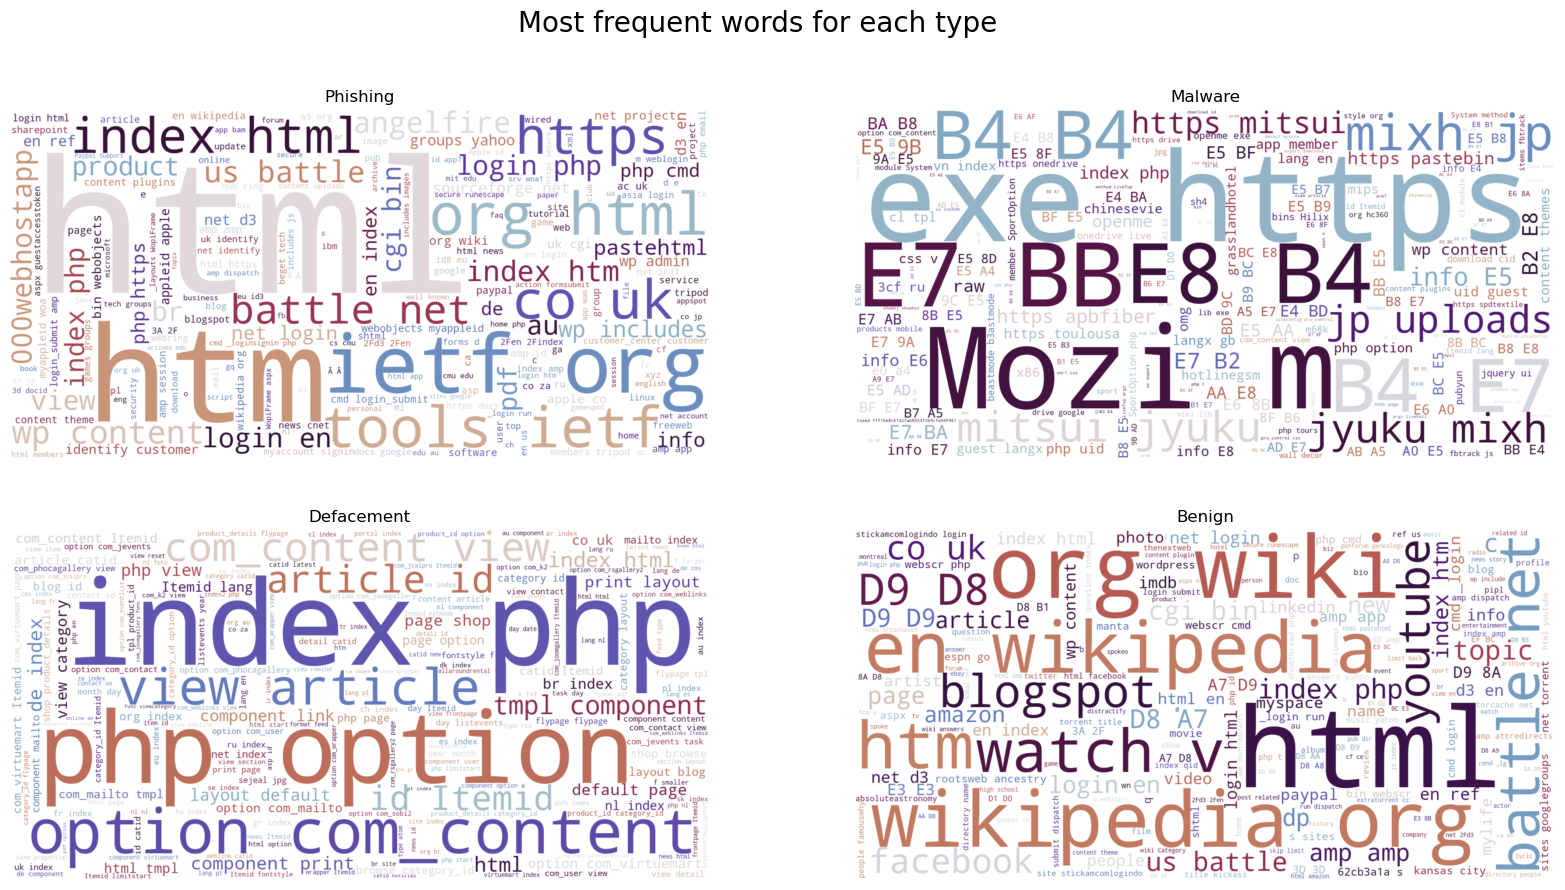

In [238]:
plt.figure(figsize=[20,10])
plt.suptitle('Most frequent words for each type',fontsize = 20)
phish_url = " ".join(i for i in df_phish.url)
wordcloud1 = WordCloud(width=1600, height=800,colormap='twilight',background_color='white').generate(phish_url)
plt.subplot(2,2,1)
plt.title('Phishing')
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')


malware_url = " ".join(i for i in df_malware.url)
wordcloud2 = WordCloud(width=1600, height=800,colormap='twilight',background_color='white').generate(malware_url)
plt.subplot(2,2,2)
plt.title('Malware')
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')


deface_url = " ".join(i for i in df_deface.url)
wordcloud3 = WordCloud(width=1600,height=800,colormap='twilight',background_color='white').generate(deface_url)
plt.subplot(2,2,3)
plt.title('Defacement')
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis('off')


benign_url = " ".join(i for i in df_benign.url)
wordcloud4 = WordCloud(width=1600, height=800,colormap='twilight',background_color='white').generate(benign_url)
plt.subplot(2,2,4)
plt.title('Benign')
plt.imshow(wordcloud4, interpolation='bilinear')
plt.axis('off')


plt.show()

## Features Selection

In [18]:
def charCount(url, feature):
    return  url.count(feature)

In [19]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    df[a] = df['url'].apply(lambda i: charCount(i,a))

In [20]:
df

,url,type,@,?,-,=,.,#,%,+,$,!,*,",",//
0,http://www.824555.com/app/member/SportOption.p...,malware,0,1,0,2,3,0,0,0,0,0,0,0,1
1,http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...,malware,0,0,0,0,1,0,21,0,0,0,0,0,1
2,http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...,malware,0,0,0,0,1,0,15,0,0,0,0,0,1
3,http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E...,malware,0,0,0,0,1,0,27,0,0,0,0,0,1
4,http://chinacxyy.com/piccodejs-000.asp?lm2=191...,malware,0,1,1,8,2,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,renew-appleid-appservice-recovry-wmiid2017-bil...,phishing,0,0,5,0,2,0,0,0,0,0,0,0,0
7996,http://www.tritunggal.ac.id/plugins/lightboxs/...,phishing,0,0,0,0,4,0,0,0,0,0,0,0,1
7997,shopismes.info,phishing,0,0,0,0,1,0,0,0,0,0,0,0,0
7998,http://appleid.apple.co.uk.cgi-bin.webobjects....,phishing,0,0,3,1,10,0,0,0,0,0,0,0,1


In [225]:
All = df.groupby('type').mean()
result = All[['@','?','-','=','.','#','%','+','$','!','*',',','//']]
result['type']=['benign','defacement','phishing','malware']
#"benign": 0, "defacement": 1, "phishing":2, "malware":3
result

,@,?,-,=,.,#,%,+,$,!,*,",",//,type
type,,,,,,,,,,,,,,
0,0.0015,0.1420,2.0500,0.2430,1.6665,0.000,0.5715,0.1005,0.0005,0.0000,0.0,0.0000,0.0940,benign
1,0.0000,0.5850,1.7095,2.3500,2.8480,0.000,0.0685,0.0170,0.0000,0.0000,0.0,0.0115,1.0000,defacement
2,0.0015,0.0795,0.5275,0.1465,2.2875,0.001,0.0415,0.0000,0.0000,0.0005,0.0,0.0015,0.3295,phishing
3,0.0010,0.2290,1.1525,0.7660,2.2535,0.000,5.2275,0.0715,0.0000,0.0030,0.0,0.0000,0.7775,malware


In [234]:
px.bar(data_frame=result,x='type',y=['?','=','.','%','//'],barmode='group',title='Average numbe of symbols for each type').update_layout(title_x=0.5)



## insights
- If there are many symbols, it is phishing

In [21]:
#https://dmitripavlutin.com/parse-url-javascript/
#https://docs.python.org/3/library/re.html
# re.search : Scan through string looking for the
# first location where the regular expression pattern produces a match,
# and return a corresponding match object. Return None if 
# no position in the string matches the pattern; note that
# this is different from finding a zero-length match at some point in the string.

In [22]:
# check if the url has a hostname or not
def HasHostname(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        return 1
    else:
        return 0
    

In [23]:
df['HasHostname'] = df['url'].apply(lambda i: HasHostname(i))

In [295]:
Host = pd.crosstab(df.type,df.HasHostname)
Host['type']=['benign','defacement','phishing','malware']
Host.rename(columns={0:'no_HostName',1:'has_HostName'},inplace=True)

In [296]:
Host

HasHostname,no_HostName,has_HostName,type
type,,,
0,1815,185,benign
1,0,2000,defacement
2,1383,617,phishing
3,470,1530,malware


In [297]:
px.bar(data_frame=Host,x=Host.type,y=['has_HostName','no_HostName'],barmode='group',title='The numbe of hostname for each type').update_layout(title_x=0.5)



### insights
- The benign type prevails (No hostname)

In [25]:
#https://python.readthedocs.io/en/v2.7.2/library/urlparse.html
# scheme return either http or https or None
# IsHttps to check if the url is https
def IsHttps(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        return 1
    else:
        return 0

In [26]:
df['IsHttps'] = df['url'].apply(lambda i: IsHttps(i))

In [27]:
df

,url,type,@,?,-,=,.,#,%,+,$,!,*,",",//,HasHostname,IsHttps
0,http://www.824555.com/app/member/SportOption.p...,malware,0,1,0,2,3,0,0,0,0,0,0,0,1,1,0
1,http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...,malware,0,0,0,0,1,0,21,0,0,0,0,0,1,1,0
2,http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...,malware,0,0,0,0,1,0,15,0,0,0,0,0,1,1,0
3,http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E...,malware,0,0,0,0,1,0,27,0,0,0,0,0,1,1,0
4,http://chinacxyy.com/piccodejs-000.asp?lm2=191...,malware,0,1,1,8,2,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,renew-appleid-appservice-recovry-wmiid2017-bil...,phishing,0,0,5,0,2,0,0,0,0,0,0,0,0,0,0
7996,http://www.tritunggal.ac.id/plugins/lightboxs/...,phishing,0,0,0,0,4,0,0,0,0,0,0,0,1,1,0
7997,shopismes.info,phishing,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
7998,http://appleid.apple.co.uk.cgi-bin.webobjects....,phishing,0,0,3,1,10,0,0,0,0,0,0,0,1,1,0


In [299]:
https = pd.crosstab(df.type,df.IsHttps)
https['type']=['benign','defacement','phishing','malware']
https.rename(columns={0:'is_not_Https',1:'is_Https'},inplace=True)

In [300]:
https

IsHttps,is_not_Https,is_Https,type
type,,,
0,1988,12,benign
1,2000,0,defacement
2,1987,13,phishing
3,1975,25,malware


In [326]:
px.bar(data_frame=https,x=https.type,y=['is_not_Https','is_Https'],barmode='group',title='The number of hostname for each type').update_layout(title_x=0.5)



### insights
- البروتكول (https) من الممكن ان يستخدمم ف التنصت والبرمجيات الخبيثة

In [28]:
# Count the number of digits in url (how many numbers there?)
def numberCount(url):
    numbers = 0
    for i in url:
        if i.isnumeric():
            numbers = numbers + 1
    return numbers

In [29]:
df['numberCount']= df['url'].apply(lambda i: numberCount(i))

In [30]:
df

,url,type,@,?,-,=,.,#,%,+,$,!,*,",",//,HasHostname,IsHttps,numberCount
0,http://www.824555.com/app/member/SportOption.p...,malware,0,1,0,2,3,0,0,0,0,0,0,0,1,1,0,6
1,http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...,malware,0,0,0,0,1,0,21,0,0,0,0,0,1,1,0,22
2,http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...,malware,0,0,0,0,1,0,15,0,0,0,0,0,1,1,0,21
3,http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E...,malware,0,0,0,0,1,0,27,0,0,0,0,0,1,1,0,30
4,http://chinacxyy.com/piccodejs-000.asp?lm2=191...,malware,0,1,1,8,2,0,0,0,0,0,0,0,1,1,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,renew-appleid-appservice-recovry-wmiid2017-bil...,phishing,0,0,5,0,2,0,0,0,0,0,0,0,0,0,0,8
7996,http://www.tritunggal.ac.id/plugins/lightboxs/...,phishing,0,0,0,0,4,0,0,0,0,0,0,0,1,1,0,0
7997,shopismes.info,phishing,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7998,http://appleid.apple.co.uk.cgi-bin.webobjects....,phishing,0,0,3,1,10,0,0,0,0,0,0,0,1,1,0,18


In [322]:
All_num = df[['type','numberCount']].groupby('type').mean()
number = pd.DataFrame()
number['numberCount'] = All_num['numberCount']
number['type']=['benign','defacement','phishing','malware']
#"benign": 0, "defacement": 1, "phishing":2, "malware":3
number

,numberCount,type
type,,
0,4.5440,benign
1,4.9515,defacement
2,3.4250,phishing
3,12.4105,malware


In [324]:
px.bar(data_frame=number,x=number.type,y=['numberCount'],barmode='group',title='The number of digits for each type').update_layout(title_x=0.5)



### insight
- The number of digits increas in Malware , Defacement and phishing 
- الارقام التي ظهرت في الحميد قد تكون بسبب البروت نمبر واسم المستخدم

In [31]:
# Count the number of alphabets in url (how many letter there?)
def alphabetCount(url):
    alphabets = 0
    for i in url:
        if i.isalpha():
            alphabets = alphabets + 1
    return alphabets

In [32]:
df['alphabetCount']= df['url'].apply(lambda i: alphabetCount(i))

In [33]:
df

,url,type,@,?,-,=,.,#,%,+,$,!,*,",",//,HasHostname,IsHttps,numberCount,alphabetCount
0,http://www.824555.com/app/member/SportOption.p...,malware,0,1,0,2,3,0,0,0,0,0,0,0,1,1,0,6,48
1,http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...,malware,0,0,0,0,1,0,21,0,0,0,0,0,1,1,0,22,32
2,http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...,malware,0,0,0,0,1,0,15,0,0,0,0,0,1,1,0,21,21
3,http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E...,malware,0,0,0,0,1,0,27,0,0,0,0,0,1,1,0,30,36
4,http://chinacxyy.com/piccodejs-000.asp?lm2=191...,malware,0,1,1,8,2,0,0,0,0,0,0,0,1,1,0,17,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,renew-appleid-appservice-recovry-wmiid2017-bil...,phishing,0,0,5,0,2,0,0,0,0,0,0,0,0,0,0,8,47
7996,http://www.tritunggal.ac.id/plugins/lightboxs/...,phishing,0,0,0,0,4,0,0,0,0,0,0,0,1,1,0,0,65
7997,shopismes.info,phishing,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,13
7998,http://appleid.apple.co.uk.cgi-bin.webobjects....,phishing,0,0,3,1,10,0,0,0,0,0,0,0,1,1,0,18,161


In [327]:
All_alph = df[['type','alphabetCount']].groupby('type').mean()
letters = pd.DataFrame()
letters['alphabetCount'] = All_alph['alphabetCount']
letters['type']=['benign','defacement','phishing','malware']

letters

,alphabetCount,type
type,,
0,40.8555,benign
1,67.4755,defacement
2,32.8865,phishing
3,45.0615,malware


In [329]:
px.bar(data_frame=letters,x=letters.type,y=['alphabetCount'],barmode='group',title='The number of letters for each type').update_layout(title_x=0.5)



### insight
- احتمالية الموقع ان يكون ضار اكبر اذا كان عدد الاحرف كبيرة

In [34]:
# Check if the url conatins the short url (tinyURL)

def shortUrl(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

In [35]:
df['shortUrl'] = df['url'].apply(lambda x: shortUrl(x))

In [36]:
df

,url,type,@,?,-,=,.,#,%,+,$,!,*,",",//,HasHostname,IsHttps,numberCount,alphabetCount,shortUrl
0,http://www.824555.com/app/member/SportOption.p...,malware,0,1,0,2,3,0,0,0,0,0,0,0,1,1,0,6,48,0
1,http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...,malware,0,0,0,0,1,0,21,0,0,0,0,0,1,1,0,22,32,0
2,http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...,malware,0,0,0,0,1,0,15,0,0,0,0,0,1,1,0,21,21,0
3,http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E...,malware,0,0,0,0,1,0,27,0,0,0,0,0,1,1,0,30,36,0
4,http://chinacxyy.com/piccodejs-000.asp?lm2=191...,malware,0,1,1,8,2,0,0,0,0,0,0,0,1,1,0,17,41,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,renew-appleid-appservice-recovry-wmiid2017-bil...,phishing,0,0,5,0,2,0,0,0,0,0,0,0,0,0,0,8,47,0
7996,http://www.tritunggal.ac.id/plugins/lightboxs/...,phishing,0,0,0,0,4,0,0,0,0,0,0,0,1,1,0,0,65,0
7997,shopismes.info,phishing,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,13,0
7998,http://appleid.apple.co.uk.cgi-bin.webobjects....,phishing,0,0,3,1,10,0,0,0,0,0,0,0,1,1,0,18,161,0


In [334]:
shortUrl = pd.crosstab(df.type,df.shortUrl)
shortUrl['type']=['benign','defacement','phishing','malware']
shortUrl.rename(columns={0:'not_use_ShorteningServices',1:'use_ShorteningServices'},inplace=True)

In [335]:
shortUrl

shortUrl,not_use_ShorteningServices,use_ShorteningServices,type
type,,,
0,1853,147,benign
1,1949,51,defacement
2,1903,97,phishing
3,1880,120,malware


In [337]:
px.bar(data_frame=shortUrl,x=shortUrl.type,y=['not_use_ShorteningServices','use_ShorteningServices'],barmode='group',title='The number of Shortening Services for each type').update_layout(title_x=0.5)



### insight
- 
- 

In [37]:
# check if url contains IPv4 or IPv6
def ipAddress(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

In [38]:
df['ipAddress'] = df['url'].apply(lambda i: ipAddress(i))

In [39]:
df

,url,type,@,?,-,=,.,#,%,+,...,!,*,",",//,HasHostname,IsHttps,numberCount,alphabetCount,shortUrl,ipAddress
0,http://www.824555.com/app/member/SportOption.p...,malware,0,1,0,2,3,0,0,0,...,0,0,0,1,1,0,6,48,0,0
1,http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...,malware,0,0,0,0,1,0,21,0,...,0,0,0,1,1,0,22,32,0,0
2,http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...,malware,0,0,0,0,1,0,15,0,...,0,0,0,1,1,0,21,21,0,0
3,http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E...,malware,0,0,0,0,1,0,27,0,...,0,0,0,1,1,0,30,36,0,0
4,http://chinacxyy.com/piccodejs-000.asp?lm2=191...,malware,0,1,1,8,2,0,0,0,...,0,0,0,1,1,0,17,41,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,renew-appleid-appservice-recovry-wmiid2017-bil...,phishing,0,0,5,0,2,0,0,0,...,0,0,0,0,0,0,8,47,0,0
7996,http://www.tritunggal.ac.id/plugins/lightboxs/...,phishing,0,0,0,0,4,0,0,0,...,0,0,0,1,1,0,0,65,0,0
7997,shopismes.info,phishing,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,13,0,0
7998,http://appleid.apple.co.uk.cgi-bin.webobjects....,phishing,0,0,3,1,10,0,0,0,...,0,0,0,1,1,0,18,161,0,0


In [338]:
ipAddress = pd.crosstab(df.type,df.ipAddress)
ipAddress['type']=['benign','defacement','phishing','malware']
ipAddress.rename(columns={0:'not_use_ipAddress',1:'use_ipAddress'},inplace=True)

In [339]:
ipAddress

ipAddress,not_use_ipAddress,use_ipAddress,type
type,,,
0,2000,0,benign
1,2000,0,defacement
2,1989,11,phishing
3,1988,12,malware


In [341]:
px.bar(data_frame=ipAddress,x=ipAddress.type,y=['not_use_ipAddress','use_ipAddress'],barmode='group',title='The number of ipAddress for each type').update_layout(title_x=0.5)



### insight 
- ان الايبي ادرس في لا يظهر في الحميدة

In [40]:
# https://pypi.org/project/python-whois/
# https://www.geeksforgeeks.org/how-to-convert-datetime-to-date-in-python/ 
'''
To get domain age:
1- get domain name using whois and urlparse
2- If url has domain name ==> extract the creation and expiration dates ==> check if the age is more than 12

if age > 12 less phishing possibility  
else higher phishing possibility 
'''

'\nTo get domain age:\n1- get domain name using whois and urlparse\n2- If url has domain name ==> extract the creation and expiration dates ==> check if the age is more than 12\n\nif age > 12 less phishing possibility  \nelse higher phishing possibility \n'

In [41]:
def ageLess12Mon(url):
  try:
    domain_name = whois.whois(urlparse(url).netloc) 
    creation_date = domain_name.creation_date
    expiration_date = domain_name.expiration_date
    if (isinstance(creation_date,str) or isinstance(expiration_date,str)):
      try:
        creation_date = datetime.strptime(creation_date,'%Y-%m-%d')
        expiration_date = datetime.strptime(expiration_date,"%Y-%m-%d")
      except:
        return 1
    if ((expiration_date is None) or (creation_date is None)):
        return 1
    else:
      ageofdomain = abs((expiration_date - creation_date).days)
      if ((ageofdomain/30) < 12):
        age = 1
      else:
        age = 0
  except:
      age = 1
 
  return age

In [42]:
df['ageLess12Mon'] = df['url'].apply(lambda i: ageLess12Mon(i))

In [43]:
df

,url,type,@,?,-,=,.,#,%,+,...,*,",",//,HasHostname,IsHttps,numberCount,alphabetCount,shortUrl,ipAddress,ageLess12Mon
0,http://www.824555.com/app/member/SportOption.p...,malware,0,1,0,2,3,0,0,0,...,0,0,1,1,0,6,48,0,0,1
1,http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...,malware,0,0,0,0,1,0,21,0,...,0,0,1,1,0,22,32,0,0,1
2,http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...,malware,0,0,0,0,1,0,15,0,...,0,0,1,1,0,21,21,0,0,1
3,http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E...,malware,0,0,0,0,1,0,27,0,...,0,0,1,1,0,30,36,0,0,1
4,http://chinacxyy.com/piccodejs-000.asp?lm2=191...,malware,0,1,1,8,2,0,0,0,...,0,0,1,1,0,17,41,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,renew-appleid-appservice-recovry-wmiid2017-bil...,phishing,0,0,5,0,2,0,0,0,...,0,0,0,0,0,8,47,0,0,1
7996,http://www.tritunggal.ac.id/plugins/lightboxs/...,phishing,0,0,0,0,4,0,0,0,...,0,0,1,1,0,0,65,0,0,1
7997,shopismes.info,phishing,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,13,0,0,1
7998,http://appleid.apple.co.uk.cgi-bin.webobjects....,phishing,0,0,3,1,10,0,0,0,...,0,0,1,1,0,18,161,0,0,1


In [342]:
ageLess12Mon = pd.crosstab(df.type,df.ageLess12Mon)
ageLess12Mon['type']=['benign','defacement','phishing','malware']
ageLess12Mon.rename(columns={0:'ageMore12Mon',1:'ageLess12Mon'},inplace=True)

In [343]:
ageLess12Mon

ageLess12Mon,ageLess12Mon,type
type,,
0,2000,benign
1,2000,defacement
2,2000,phishing
3,2000,malware


In [345]:
px.bar(data_frame=ageLess12Mon,x=ageLess12Mon.type,y=['ageLess12Mon'],barmode='group',title='The number of age Less 12 Month for each type').update_layout(title_x=0.5)



### insight
- 
-

In [44]:
'''
To get domain end:
1- get domain name using whois and urlparse
2- If url has domain name ==> extract the expiration date ==> check if the end is less than 6

if end > 6 less phishing possibility  
else higher phishing possibility 
'''

'\nTo get domain end:\n1- get domain name using whois and urlparse\n2- If url has domain name ==> extract the expiration date ==> check if the end is less than 6\n\nif end > 6 less phishing possibility  \nelse higher phishing possibility \n'

In [45]:
def endLess6Mon(url):
  try:
    domain_name = whois.whois(urlparse(url).netloc)
    expiration_date = domain_name.expiration_date
    if isinstance(expiration_date,str):
      try:
        expiration_date = datetime.strptime(expiration_date,"%Y-%m-%d")
      except:
        return 1
    if (expiration_date is None):
        return 1
    else:
      today = datetime.now()
      end = abs((expiration_date - today).days)
      if ((end/30) < 6):
        end = 1
      else:
        end = 0
  except:
    end = 1

  return end

In [46]:
df['endLess6Mon'] = df['url'].apply(lambda i: endLess6Mon(i))

In [47]:
df

,url,type,@,?,-,=,.,#,%,+,...,",",//,HasHostname,IsHttps,numberCount,alphabetCount,shortUrl,ipAddress,ageLess12Mon,endLess6Mon
0,http://www.824555.com/app/member/SportOption.p...,malware,0,1,0,2,3,0,0,0,...,0,1,1,0,6,48,0,0,1,1
1,http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...,malware,0,0,0,0,1,0,21,0,...,0,1,1,0,22,32,0,0,1,1
2,http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...,malware,0,0,0,0,1,0,15,0,...,0,1,1,0,21,21,0,0,1,1
3,http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E...,malware,0,0,0,0,1,0,27,0,...,0,1,1,0,30,36,0,0,1,1
4,http://chinacxyy.com/piccodejs-000.asp?lm2=191...,malware,0,1,1,8,2,0,0,0,...,0,1,1,0,17,41,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,renew-appleid-appservice-recovry-wmiid2017-bil...,phishing,0,0,5,0,2,0,0,0,...,0,0,0,0,8,47,0,0,1,1
7996,http://www.tritunggal.ac.id/plugins/lightboxs/...,phishing,0,0,0,0,4,0,0,0,...,0,1,1,0,0,65,0,0,1,1
7997,shopismes.info,phishing,0,0,0,0,1,0,0,0,...,0,0,0,0,0,13,0,0,1,1
7998,http://appleid.apple.co.uk.cgi-bin.webobjects....,phishing,0,0,3,1,10,0,0,0,...,0,1,1,0,18,161,0,0,1,1


In [346]:
endLess6Mon = pd.crosstab(df.type,df.endLess6Mon)
endLess6Mon['type']=['benign','defacement','phishing','malware']
endLess6Mon.rename(columns={0:'ageMore6Mon',1:'endLess6Mon'},inplace=True)
endLess6Mon

endLess6Mon,endLess6Mon,type
type,,
0,2000,benign
1,2000,defacement
2,2000,phishing
3,2000,malware


In [347]:
px.bar(data_frame=endLess6Mon,x=endLess6Mon.type,y=['endLess6Mon'],barmode='group',title='The number of end Less 6 Month for each type').update_layout(title_x=0.5)



### insight
-
-

In [48]:
# phishing sites use iframe tags to create invisible links that users maybe click it
def hasIfram(url):
    try:
        response = requests.get(url)
        if re.findall(r"[<iframe>|<frameBorder>]", response.text):
            return 0
        else:
            return 1
    except:
        return 1
    

In [49]:
df['hasIfram'] = df['url'].apply(lambda i: hasIfram(i))

In [50]:
df

,url,type,@,?,-,=,.,#,%,+,...,//,HasHostname,IsHttps,numberCount,alphabetCount,shortUrl,ipAddress,ageLess12Mon,endLess6Mon,hasIfram
0,http://www.824555.com/app/member/SportOption.p...,malware,0,1,0,2,3,0,0,0,...,1,1,0,6,48,0,0,1,1,0
1,http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...,malware,0,0,0,0,1,0,21,0,...,1,1,0,22,32,0,0,1,1,0
2,http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...,malware,0,0,0,0,1,0,15,0,...,1,1,0,21,21,0,0,1,1,0
3,http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E...,malware,0,0,0,0,1,0,27,0,...,1,1,0,30,36,0,0,1,1,0
4,http://chinacxyy.com/piccodejs-000.asp?lm2=191...,malware,0,1,1,8,2,0,0,0,...,1,1,0,17,41,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,renew-appleid-appservice-recovry-wmiid2017-bil...,phishing,0,0,5,0,2,0,0,0,...,0,0,0,8,47,0,0,1,1,1
7996,http://www.tritunggal.ac.id/plugins/lightboxs/...,phishing,0,0,0,0,4,0,0,0,...,1,1,0,0,65,0,0,1,1,1
7997,shopismes.info,phishing,0,0,0,0,1,0,0,0,...,0,0,0,0,13,0,0,1,1,1
7998,http://appleid.apple.co.uk.cgi-bin.webobjects....,phishing,0,0,3,1,10,0,0,0,...,1,1,0,18,161,0,0,1,1,1


In [351]:
hasIfram = pd.crosstab(df.type,df.hasIfram)
hasIfram['type']=['benign','defacement','phishing','malware']
hasIfram.rename(columns={0:'not_has_Ifram',1:'has_Ifram'},inplace=True)
hasIfram

hasIfram,not_has_Ifram,has_Ifram,type
type,,,
0,0,2000,benign
1,0,2000,defacement
2,0,2000,phishing
3,175,1825,malware


In [352]:
px.bar(data_frame=hasIfram,x=hasIfram.type,y=['not_has_Ifram','has_Ifram'],barmode='group',title='The number of URL has Ifram for each type').update_layout(title_x=0.5)



### insight
- Benign type must have ifram

In [51]:
# https://www.google.com/url?sa=i&url=https%3A%2F%2Fsecurity.stackexchange.com%2Fquestions%2F41527%2Fis-the-web-browser-status-bar-always-trustable&psig=AOvVaw2cVoaiFrxGEx2u2o6La9e4&ust=1677095551544000&source=images&cd=vfe&ved=0CBAQjRxqFwoTCKi81vaxp_0CFQAAAAAdAAAAABAD
# phishing sites use mouseover event from javascript to hide fake url
def hasMouseOver(url): 
  try:
    response = requests.get(url)
    if re.findall("<script>.+onmouseover.+</script>", response.text):
      return 1
    else:
      return 0
  except:
        return 1

In [52]:
df['hasMouseOver'] = df['url'].apply(lambda i: hasMouseOver(i))

In [53]:
df

,url,type,@,?,-,=,.,#,%,+,...,HasHostname,IsHttps,numberCount,alphabetCount,shortUrl,ipAddress,ageLess12Mon,endLess6Mon,hasIfram,hasMouseOver
0,http://www.824555.com/app/member/SportOption.p...,malware,0,1,0,2,3,0,0,0,...,1,0,6,48,0,0,1,1,0,1
1,http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...,malware,0,0,0,0,1,0,21,0,...,1,0,22,32,0,0,1,1,0,1
2,http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...,malware,0,0,0,0,1,0,15,0,...,1,0,21,21,0,0,1,1,0,1
3,http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E...,malware,0,0,0,0,1,0,27,0,...,1,0,30,36,0,0,1,1,0,1
4,http://chinacxyy.com/piccodejs-000.asp?lm2=191...,malware,0,1,1,8,2,0,0,0,...,1,0,17,41,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,renew-appleid-appservice-recovry-wmiid2017-bil...,phishing,0,0,5,0,2,0,0,0,...,0,0,8,47,0,0,1,1,1,1
7996,http://www.tritunggal.ac.id/plugins/lightboxs/...,phishing,0,0,0,0,4,0,0,0,...,1,0,0,65,0,0,1,1,1,1
7997,shopismes.info,phishing,0,0,0,0,1,0,0,0,...,0,0,0,13,0,0,1,1,1,1
7998,http://appleid.apple.co.uk.cgi-bin.webobjects....,phishing,0,0,3,1,10,0,0,0,...,1,0,18,161,0,0,1,1,1,1


In [354]:
hasMouseOver = pd.crosstab(df.type,df.hasMouseOver)
hasMouseOver['type']=['benign','defacement','phishing','malware']
hasMouseOver.rename(columns={0:'not_has_Mouse_Over',1:'has_Mouse_Over'},inplace=True)
hasMouseOver

hasMouseOver,has_Mouse_Over,type
type,,
0,2000,benign
1,2000,defacement
2,2000,phishing
3,2000,malware


In [358]:
px.bar(data_frame=hasMouseOver,x=hasMouseOver.type,y=['has_Mouse_Over'],barmode='group',title='The number of URL has Mouse Over for each type').update_layout(title_x=0.5)



In [54]:
# This part explained in the paper, disabled the right click option so the user cann't incpect the webpage
def disabledRightClick(url): 
  try:
    response = requests.get(url)
    if re.findall(r"event.button ?== ?2", response.text):
      return 0
    else:
      return 1
  except:
        return 1

In [55]:
df['disabledRightClick'] = df['url'].apply(lambda i: disabledRightClick(i))

In [56]:
df

,url,type,@,?,-,=,.,#,%,+,...,IsHttps,numberCount,alphabetCount,shortUrl,ipAddress,ageLess12Mon,endLess6Mon,hasIfram,hasMouseOver,disabledRightClick
0,http://www.824555.com/app/member/SportOption.p...,malware,0,1,0,2,3,0,0,0,...,0,6,48,0,0,1,1,0,1,1
1,http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...,malware,0,0,0,0,1,0,21,0,...,0,22,32,0,0,1,1,0,1,1
2,http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...,malware,0,0,0,0,1,0,15,0,...,0,21,21,0,0,1,1,0,1,1
3,http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E...,malware,0,0,0,0,1,0,27,0,...,0,30,36,0,0,1,1,0,1,1
4,http://chinacxyy.com/piccodejs-000.asp?lm2=191...,malware,0,1,1,8,2,0,0,0,...,0,17,41,0,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,renew-appleid-appservice-recovry-wmiid2017-bil...,phishing,0,0,5,0,2,0,0,0,...,0,8,47,0,0,1,1,1,1,1
7996,http://www.tritunggal.ac.id/plugins/lightboxs/...,phishing,0,0,0,0,4,0,0,0,...,0,0,65,0,0,1,1,1,1,1
7997,shopismes.info,phishing,0,0,0,0,1,0,0,0,...,0,0,13,0,0,1,1,1,1,1
7998,http://appleid.apple.co.uk.cgi-bin.webobjects....,phishing,0,0,3,1,10,0,0,0,...,0,18,161,0,0,1,1,1,1,1


In [360]:
disabledRightClick = pd.crosstab(df.type,df.disabledRightClick)
disabledRightClick['type']=['benign','defacement','phishing','malware']
disabledRightClick.rename(columns={0:'not_has_disabled_RightClick',1:'has_disabled_RightClick'},inplace=True)
disabledRightClick

disabledRightClick,has_disabled_RightClick,type
type,,
0,2000,benign
1,2000,defacement
2,2000,phishing
3,2000,malware


In [361]:
px.bar(data_frame=disabledRightClick,x=disabledRightClick.type,y=['has_disabled_RightClick'],barmode='group',title='The number of URL has disabled RightClick for each type').update_layout(title_x=0.5)



In [57]:
# This part explained in the paper, multiple redirect webpages have a high possibility to be a phising websits
def isMultiDirected(url): 
  try:
    response = requests.get(url)
    if len(response.history) <= 2:
      return 0
    else:
      return 1
  except:
        return 1

In [58]:
df['isMultiDirected'] = df['url'].apply(lambda i: isMultiDirected(i))

In [59]:
df

,url,type,@,?,-,=,.,#,%,+,...,numberCount,alphabetCount,shortUrl,ipAddress,ageLess12Mon,endLess6Mon,hasIfram,hasMouseOver,disabledRightClick,isMultiDirected
0,http://www.824555.com/app/member/SportOption.p...,malware,0,1,0,2,3,0,0,0,...,6,48,0,0,1,1,0,1,1,1
1,http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...,malware,0,0,0,0,1,0,21,0,...,22,32,0,0,1,1,0,1,1,1
2,http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...,malware,0,0,0,0,1,0,15,0,...,21,21,0,0,1,1,0,1,1,1
3,http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E...,malware,0,0,0,0,1,0,27,0,...,30,36,0,0,1,1,0,1,1,1
4,http://chinacxyy.com/piccodejs-000.asp?lm2=191...,malware,0,1,1,8,2,0,0,0,...,17,41,0,0,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,renew-appleid-appservice-recovry-wmiid2017-bil...,phishing,0,0,5,0,2,0,0,0,...,8,47,0,0,1,1,1,1,1,1
7996,http://www.tritunggal.ac.id/plugins/lightboxs/...,phishing,0,0,0,0,4,0,0,0,...,0,65,0,0,1,1,1,1,1,1
7997,shopismes.info,phishing,0,0,0,0,1,0,0,0,...,0,13,0,0,1,1,1,1,1,1
7998,http://appleid.apple.co.uk.cgi-bin.webobjects....,phishing,0,0,3,1,10,0,0,0,...,18,161,0,0,1,1,1,1,1,1


In [363]:
isMultiDirected = pd.crosstab(df.type,df.isMultiDirected)
isMultiDirected['type']=['benign','defacement','phishing','malware']
isMultiDirected.rename(columns={0:'is_not_Multi_Directed',1:'is_Multi_Directed'},inplace=True)
isMultiDirected

isMultiDirected,is_Multi_Directed,type
type,,
0,2000,benign
1,2000,defacement
2,2000,phishing
3,2000,malware


In [364]:
px.bar(data_frame=isMultiDirected,x=isMultiDirected.type,y=['is_Multi_Directed'],barmode='group',title='The number of URL has Multi Directed for each type').update_layout(title_x=0.5)



## insight
-
-

# Models

In [365]:
modelData = df.copy()

In [366]:
modelData

,url,type,@,?,-,=,.,#,%,+,...,numberCount,alphabetCount,shortUrl,ipAddress,ageLess12Mon,endLess6Mon,hasIfram,hasMouseOver,disabledRightClick,isMultiDirected
0,http://www.824555.com/app/member/SportOption.p...,3,0,1,0,2,3,0,0,0,...,6,48,0,0,1,1,0,1,1,1
1,http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...,3,0,0,0,0,1,0,21,0,...,22,32,0,0,1,1,0,1,1,1
2,http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...,3,0,0,0,0,1,0,15,0,...,21,21,0,0,1,1,0,1,1,1
3,http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E...,3,0,0,0,0,1,0,27,0,...,30,36,0,0,1,1,0,1,1,1
4,http://chinacxyy.com/piccodejs-000.asp?lm2=191...,3,0,1,1,8,2,0,0,0,...,17,41,0,0,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,renew-appleid-appservice-recovry-wmiid2017-bil...,2,0,0,5,0,2,0,0,0,...,8,47,0,0,1,1,1,1,1,1
7996,http://www.tritunggal.ac.id/plugins/lightboxs/...,2,0,0,0,0,4,0,0,0,...,0,65,0,0,1,1,1,1,1,1
7997,shopismes.info,2,0,0,0,0,1,0,0,0,...,0,13,0,0,1,1,1,1,1,1
7998,http://appleid.apple.co.uk.cgi-bin.webobjects....,2,0,0,3,1,10,0,0,0,...,18,161,0,0,1,1,1,1,1,1


In [72]:
df['type'] = df['type'] .map({"benign": 0, "defacement": 1, "phishing":2, "malware":3})

In [367]:
modelData['type'] = modelData['type'].map({0: 0, 1: 1, 2:1, 3:1})

In [368]:
modelData['type']

0       1
1       1
2       1
3       1
4       1
       ..
7995    1
7996    1
7997    1
7998    1
7999    1
Name: type, Length: 8000, dtype: int64

In [369]:
X = modelData.drop(columns=['url','type'],axis=1)
y = modelData['type']

In [370]:
X.head()

,@,?,-,=,.,#,%,+,$,!,...,numberCount,alphabetCount,shortUrl,ipAddress,ageLess12Mon,endLess6Mon,hasIfram,hasMouseOver,disabledRightClick,isMultiDirected
0,0,1,0,2,3,0,0,0,0,0,...,6,48,0,0,1,1,0,1,1,1
1,0,0,0,0,1,0,21,0,0,0,...,22,32,0,0,1,1,0,1,1,1
2,0,0,0,0,1,0,15,0,0,0,...,21,21,0,0,1,1,0,1,1,1
3,0,0,0,0,1,0,27,0,0,0,...,30,36,0,0,1,1,0,1,1,1
4,0,1,1,8,2,0,0,0,0,0,...,17,41,0,0,1,1,0,1,1,1


In [373]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: type, dtype: int64

In [371]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
@,8000.0,0.001000,0.031609,0.0,0.0,0.0,0.0,1.0
?,8000.0,0.258875,0.452918,0.0,0.0,0.0,1.0,3.0
-,8000.0,1.359875,2.638036,0.0,0.0,0.0,1.0,28.0
=,8000.0,0.876375,1.914628,0.0,0.0,0.0,1.0,19.0
.,8000.0,2.263875,1.473267,1.0,1.0,2.0,3.0,17.0
#,8000.0,0.000250,0.015810,0.0,0.0,0.0,0.0,1.0
%,8000.0,1.477250,6.419239,0.0,0.0,0.0,0.0,98.0
+,8000.0,0.047250,0.508724,0.0,0.0,0.0,0.0,17.0
$,8000.0,0.000125,0.011180,0.0,0.0,0.0,0.0,1.0
!,8000.0,0.000875,0.040304,0.0,0.0,0.0,0.0,2.0


In [374]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [375]:
from sklearn import tree

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 20)
print("The shape of X_train is      ", X_train.shape)
print("The shape of X_test is       ",X_test.shape)
print("The shape of y_train is      ",y_train.shape)
print("The shape of y_test is       ",y_test.shape)



The shape of X_train is       (6400, 25)
The shape of X_test is        (1600, 25)
The shape of y_train is       (6400,)
The shape of y_test is        (1600,)


In [382]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

--------------------Start-----------------
-----Model => <class 'sklearn.tree._classes.DecisionTreeClassifier'> 
Test Accuracy :  88.00%  
Train Accuracy :  94.52%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.78      0.71      0.74       393
           1       0.91      0.94      0.92      1207

    accuracy                           0.88      1600
   macro avg       0.84      0.82      0.83      1600
weighted avg       0.88      0.88      0.88      1600

             Confusion_matrix 


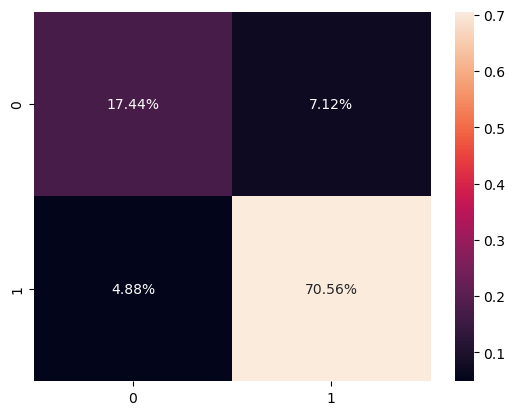

----------------- End --------------
--------------------Start-----------------
-----Model => <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
Test Accuracy :  90.69%  
Train Accuracy :  94.52%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.87      0.74      0.80       393
           1       0.92      0.96      0.94      1207

    accuracy                           0.91      1600
   macro avg       0.89      0.85      0.87      1600
weighted avg       0.90      0.91      0.90      1600

             Confusion_matrix 


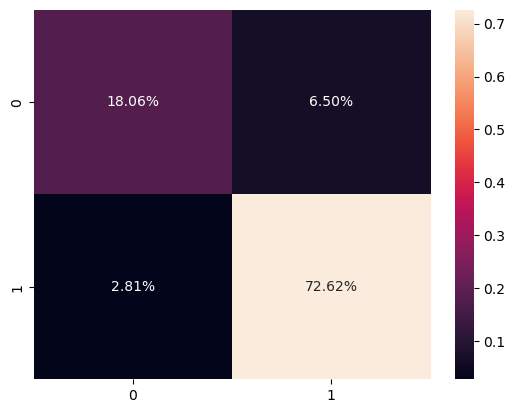

----------------- End --------------
--------------------Start-----------------
-----Model => <class 'sklearn.neighbors._classification.KNeighborsClassifier'> 
Test Accuracy :  90.38%  
Train Accuracy :  94.52%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.85      0.74      0.79       393
           1       0.92      0.96      0.94      1207

    accuracy                           0.90      1600
   macro avg       0.88      0.85      0.86      1600
weighted avg       0.90      0.90      0.90      1600

             Confusion_matrix 


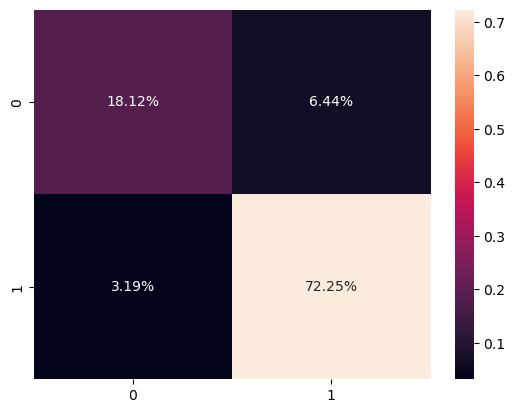

----------------- End --------------
--------------------Start-----------------
-----Model => <class 'sklearn.linear_model._logistic.LogisticRegression'> 
Test Accuracy :  87.00%  
Train Accuracy :  94.52%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.83      0.60      0.69       393
           1       0.88      0.96      0.92      1207

    accuracy                           0.87      1600
   macro avg       0.85      0.78      0.80      1600
weighted avg       0.87      0.87      0.86      1600

             Confusion_matrix 


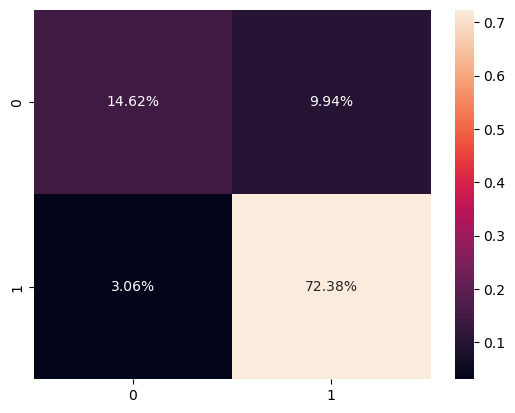

----------------- End --------------


In [383]:
models = [DecisionTreeClassifier,RandomForestClassifier,KNeighborsClassifier,LogisticRegression]
accuracy_test=[]
for m in models:
    print("--------------------Start-----------------")
    print('-----Model =>\033[07m {} \033[0m'.format(m))
    model_ = m()
    model_.fit(X_train, y_train)
    pred = model_.predict(X_test)
    acc = accuracy_score(pred, y_test)
    
    train_yhat = dt.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    
    
    accuracy_test.append(acc)
    print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))
    print('Train Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(train_acc*100))
    print('\033[01m              Classification_report \033[0m')
    print(classification_report(y_test, pred))
    print('\033[01m             Confusion_matrix \033[0m')
    cf_matrix = confusion_matrix(y_test, pred)
    plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
    plt.show()
    print('\033[31m----------------- End --------------\033[0m')